## XGBoost

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

print(xgb.__version__)

1.7.3


### 파이썬 래퍼 XGBoost (API) 적용 - 위스콘신 유방암 예측

In [2]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 데이터 로딩 및 확인
dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)   # 31개의 속성값을 가지는 결과 확인
cancer_df['target'] = labels   # 악성/양성 판단하는 타깃 레이블은 target에서 0,1로 나타남 
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)   # 타깃 레이블
print(cancer_df['target'].value_counts())   # 분포 확인

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [4]:
# cancer_df에서 feature용 DF, label용 Series 객체 추출
# 맨 마지막 칼럼에 label이 있으므로 마지막에서 두번째 칼럼까지 feature 추출 (:-1 슬라이싱)
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 테스트용 data를 20%로 추출, 학습용 data를 80%로 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 학습용 data를 다시 분리 (검증용 10%)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [5]:
# 전용 데이터 객체 DMatrix 생성
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [6]:
# 하이퍼파라미터 설정
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_rounds = 400

In [7]:
# 학습 수행

# 학습데이터셋-train, 평가데이터셋-eval 로 명기
eval_list = [(dtr, 'train'), (dval, 'eval')]


# 하이퍼 파라미터 전달
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds,
                     early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.60931	eval-logloss:0.63234
[1]	train-logloss:0.54033	eval-logloss:0.59133
[2]	train-logloss:0.48245	eval-logloss:0.55548
[3]	train-logloss:0.43082	eval-logloss:0.51440
[4]	train-logloss:0.38662	eval-logloss:0.48186
[5]	train-logloss:0.35031	eval-logloss:0.46087
[6]	train-logloss:0.31681	eval-logloss:0.43670
[7]	train-logloss:0.28716	eval-logloss:0.41290
[8]	train-logloss:0.26204	eval-logloss:0.39283
[9]	train-logloss:0.23912	eval-logloss:0.37862
[10]	train-logloss:0.21881	eval-logloss:0.36538
[11]	train-logloss:0.20090	eval-logloss:0.35174
[12]	train-logloss:0.18450	eval-logloss:0.33945
[13]	train-logloss:0.16993	eval-logloss:0.33112
[14]	train-logloss:0.15687	eval-logloss:0.32188
[15]	train-logloss:0.14536	eval-logloss:0.31217
[16]	train-logloss:0.13488	eval-logloss:0.30588
[17]	train-logloss:0.12530	eval-logloss:0.30019
[18]	train-logloss:0.11670	eval-logloss:0.29251
[19]	train-logloss:0.10906	eval-logloss:0.28847
[20]	train-logloss:0.10228	eval-logloss:0.28341
[2

In [8]:
# 테스트 데이터 예측 수행
pred_probs = xgb_model.predict(dtest)    # 예측 확률을 리턴함
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률 0.5보다 크면 1, 아니면 0으로 예측값 결정
preds = [1 if x > 0.5 else  0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.882 0.005 0.654 0.075 0.981 0.999 0.999 0.999 0.997 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


#### 모델의 예측 성능 평가

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

# 앞에서 복붙
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9930


#### 시각화

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

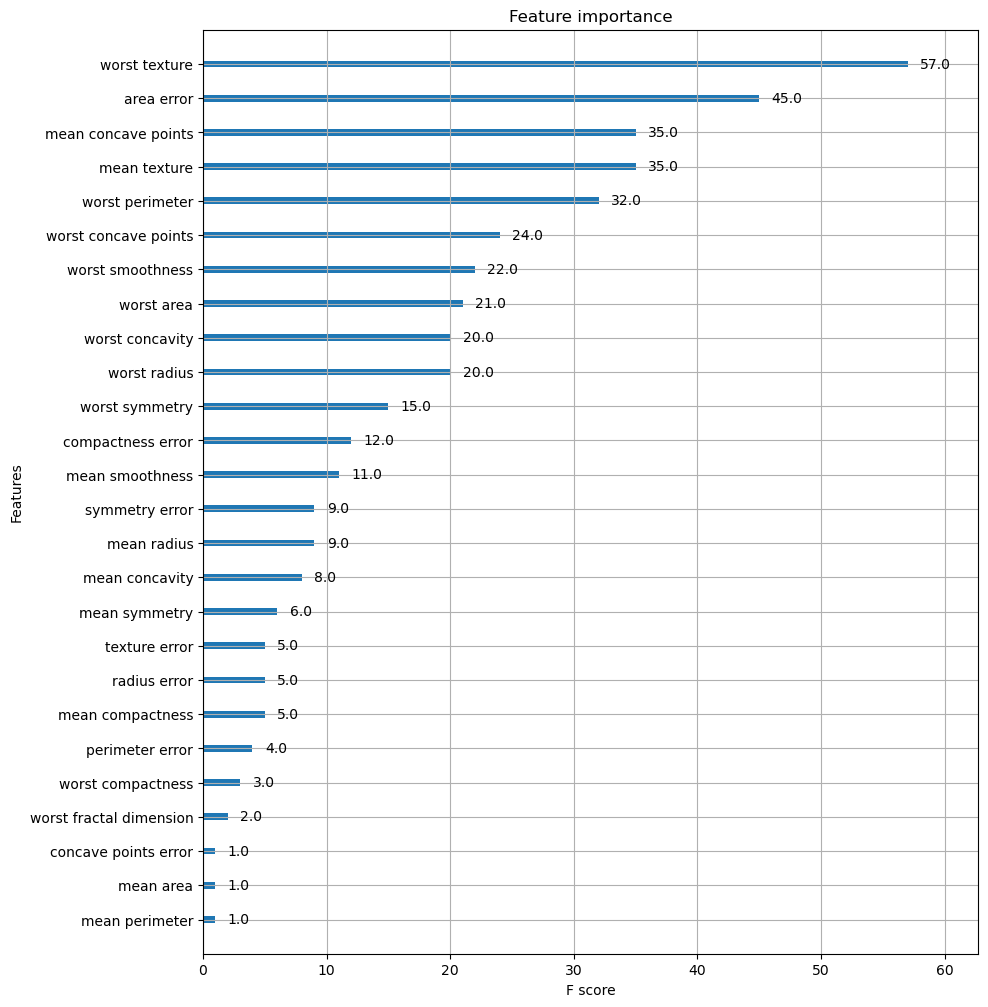

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

#### Sklearn 래퍼 XGBoost

In [11]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9954


In [12]:
# 조기 중단 수행해보기
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]

# 조기 중단 관련 파라미터를 fit()에 입력
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

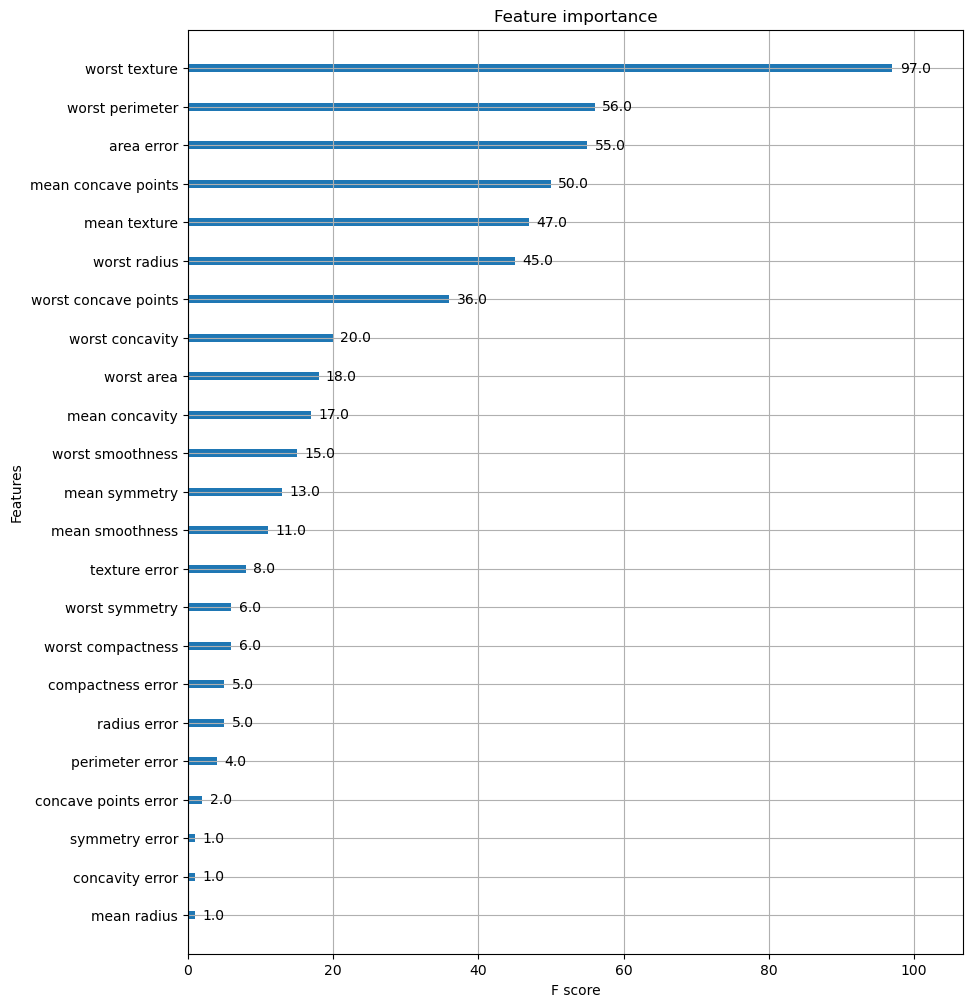

In [13]:
# 피처 중요도 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)

### LightGBM

In [16]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)

cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]


# 학습용 80%, 테스트용 20%
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)


# 학습용 다시 쪼개기 : 학습용 90%, 검증용 10%
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)


# n_estimator 400으로 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)


# 조기 중단 수행 가능, 학습/예측
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [17]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

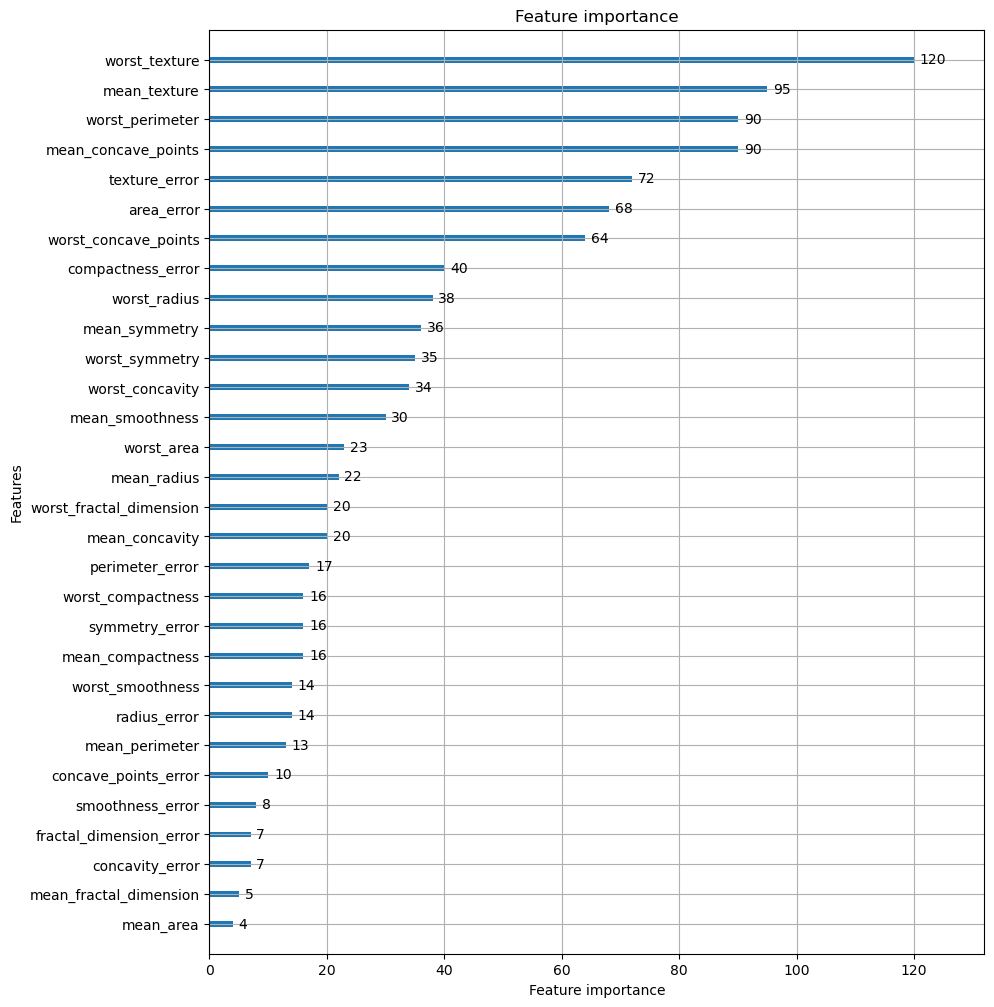

In [18]:
# feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)